In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.1 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.0 MB/s eta 0:00:00
Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.5.11 OK


In [4]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [5]:
!pip -q install icrawler

In [6]:
from pathlib import Path
from icrawler.builtin import BingImageCrawler  # 也可以换 GoogleImageCrawler

In [14]:
from pathlib import Path
from icrawler.builtin import BingImageCrawler
from PIL import Image
import numpy as np
import os

# ====== 配置 ======
path = Path('bears')
path.mkdir(exist_ok=True)

bear_types = ['black', 'grizzly', 'teddy']
TARGET = 50
MAX_ROUNDS = 8          # 每类最多补爬轮次
PER_ROUND = 120         # 每轮爬多少（会被清洗掉一部分，所以要多）
THREADS = 8

# ====== 关键词（含备用）======
def queries(o):
    neg = '-collage -infographic -poster -chart -comparison -meme -logo -icon'
    if o == 'black':
        return [
            f'American black bear wildlife photo {neg} -cartoon -drawing -illustration',
            f'black bear in the wild photo {neg} -cartoon -drawing -illustration',
        ]
    if o == 'grizzly':
        return [
            f'grizzly bear in the wild photo {neg} -cartoon -drawing -illustration',
            f'Alaskan grizzly bear wildlife photo {neg} -cartoon -drawing -illustration',
        ]
    # teddy = 玩具：明确 plush/stuffed/toy
    return [
        f'teddy bear plush toy photo {neg} -cartoon -drawing -illustration',
        f'stuffed teddy bear toy photo {neg} -cartoon -drawing -illustration',
        f'teddy bear plush close up photo {neg} -cartoon -drawing -illustration',
    ]

# ====== 更强清洗：判坏图 ======
def is_bad_image(p: Path,
                 min_side=256,
                 max_aspect=2.2,
                 std_thr=12.0,
                 edge_thr=0.030,
                 bright_min=10.0,
                 bright_max=245.0):
    """
    规则解释（都很“通俗”）：
    1) 太小：缩略图/图标/占位
    2) 长宽比太极端：海报/长条图/拼图常见
    3) 纹理太少：纯黑/纯白/纯色背景/布料（std 很低）
    4) 边缘太少：大块平滑背景（信息量低）
    5) 过暗/过亮：黑屏/白底占位图（平均亮度极端）
    """
    try:
        im = Image.open(p).convert('RGB')
        w, h = im.size
        if min(w, h) < min_side:
            return True

        aspect = max(w/h, h/w)
        if aspect > max_aspect:
            return True

        a = np.asarray(im, dtype=np.float32)
        gray = a.mean(axis=2)

        m = float(gray.mean())
        s = float(gray.std())
        if m < bright_min or m > bright_max:
            return True
        if s < std_thr:
            return True

        # “边缘量”估计：用简单梯度，抓掉“只有背景纹理/纯背景”的图
        dx = np.abs(gray[:, 1:] - gray[:, :-1])
        dy = np.abs(gray[1:, :] - gray[:-1, :])
        edge_score = float(dx.mean() + dy.mean()) / 255.0
        if edge_score < edge_thr:
            return True

        return False
    except:
        return True

def list_images(dest: Path):
    exts = {'.jpg', '.jpeg', '.png', '.webp'}
    return sorted([p for p in dest.rglob('*') if p.suffix.lower() in exts])

def clean_folder(dest: Path):
    removed = 0
    for p in list_images(dest):
        if is_bad_image(p):
            try:
                p.unlink()
                removed += 1
            except:
                pass
    return removed

# ====== 主流程：保证每类最终=50 ======
for o in bear_types:
    dest = path/o
    dest.mkdir(exist_ok=True)

    qs = queries(o)
    qi = 0

    for r in range(MAX_ROUNDS):
        # 先清一次
        clean_folder(dest)
        cur = len(list_images(dest))
        if cur >= TARGET:
            break

        q = qs[qi % len(qs)]
        qi += 1

        crawler = BingImageCrawler(storage={'root_dir': str(dest)}, downloader_threads=THREADS)
        crawler.crawl(
            keyword=q,
            max_num=PER_ROUND,
            filters={'type': 'photo', 'size': 'large'}
        )

        removed = clean_folder(dest)
        cur = len(list_images(dest))
        print(f'{o}: round {r+1} -> kept {cur}/{TARGET} (removed {removed})')

    # 如果还是不够：放宽一点点清洗阈值再尝试补齐（确保你“尽量”能拿到50）
    # 注意：这一步是为了“保证数量”，可能会牺牲一点点质量；你也可以删掉这段更严格。
    if len(list_images(dest)) < TARGET:
        print(f'{o}: still not enough, relaxing thresholds a bit to fill...')
        def is_bad_relaxed(p):
            return is_bad_image(p, min_side=224, max_aspect=2.6, std_thr=9.0, edge_thr=0.022)

        def clean_relaxed(d):
            removed2 = 0
            for p in list_images(d):
                if is_bad_relaxed(p):
                    p.unlink()
                    removed2 += 1
            return removed2

        for r in range(4):
            cur = len(list_images(dest))
            if cur >= TARGET:
                break
            q = qs[qi % len(qs)]
            qi += 1
            crawler = BingImageCrawler(storage={'root_dir': str(dest)}, downloader_threads=THREADS)
            crawler.crawl(keyword=q, max_num=PER_ROUND, filters={'type': 'photo', 'size': 'large'})
            clean_relaxed(dest)
            print(f'{o}: relaxed fill {r+1} -> kept {len(list_images(dest))}/{TARGET}')

    # 多了就裁到刚好 TARGET（稳定输出）
    imgs = list_images(dest)
    for p in imgs[TARGET:]:
        p.unlink()

    print(f'{o}: FINAL {len(list_images(dest))}/{TARGET}')





black: round 1 -> kept 45/50 (removed 6)


ERROR:downloader:Response status code 403, file https://c.stocksy.com/a/XJC000/z9/47339.jpg


black: round 2 -> kept 41/50 (removed 7)


ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/cb/23/black_bear_eating_dandelions_wildlife_nature_big_fur_habitat-732821.jpg
ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/08/11/black_bear_bear_louisiana_louisiana_black_bear_black_animal_wildlife_fur-695983.jpg
ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/88/67/black_bear_cub_looking_wildlife_nature_outdoors_wild_weeds-859214.jpg
ERROR:downloader:Response status code 406, file https://www.oklahoman.com/gcdn/authoring/authoring-images/2024/08/26/NOKL/74955534007-nabj-headshot.jpg
ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/62/9d/black_bear_meadow_wild_wildlife_outdoors_nature_predator_forest-1294942.jpg


black: round 3 -> kept 43/50 (removed 8)
black: round 4 -> kept 43/50 (removed 0)
black: round 5 -> kept 45/50 (removed 3)
black: round 6 -> kept 45/50 (removed 0)


ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/88/67/black_bear_cub_looking_wildlife_nature_outdoors_wild_weeds-859214.jpg
ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/08/11/black_bear_bear_louisiana_louisiana_black_bear_black_animal_wildlife_fur-695983.jpg
ERROR:downloader:Response status code 406, file https://www.oklahoman.com/gcdn/authoring/authoring-images/2024/08/26/NOKL/74955534007-nabj-headshot.jpg
ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/62/9d/black_bear_meadow_wild_wildlife_outdoors_nature_predator_forest-1294942.jpg


black: round 7 -> kept 46/50 (removed 7)
black: round 8 -> kept 46/50 (removed 0)
black: still not enough, relaxing thresholds a bit to fill...


ERROR:downloader:Response status code 406, file https://www.oklahoman.com/gcdn/authoring/authoring-images/2024/08/26/NOKL/74955534007-nabj-headshot.jpg
ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/08/11/black_bear_bear_louisiana_louisiana_black_bear_black_animal_wildlife_fur-695983.jpg
ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/62/9d/black_bear_meadow_wild_wildlife_outdoors_nature_predator_forest-1294942.jpg
ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/88/67/black_bear_cub_looking_wildlife_nature_outdoors_wild_weeds-859214.jpg


black: relaxed fill 1 -> kept 49/50
black: relaxed fill 2 -> kept 49/50
black: relaxed fill 3 -> kept 50/50
black: FINAL 50/50
grizzly: round 1 -> kept 51/50 (removed 11)
grizzly: FINAL 50/50


ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/016/151/685/large_2x/cartoon-teddy-bear-plush-toy-icon-in-comic-style-teddy-toy-sign-illustration-pictogram-bear-business-splash-effect-concept-vector.jpg
ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/018/827/748/original/cartoon-teddy-bear-plush-toy-icon-in-comic-style-teddy-toy-sign-illustration-pictogram-bear-business-splash-effect-concept-vector.jpg
ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/018/828/293/large_2x/cartoon-teddy-bear-plush-toy-icon-in-comic-style-teddy-toy-sign-illustration-pictogram-bear-business-splash-effect-concept-vector.jpg
ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/45/d1/teddy_bear_plush_toy_bear_children's_play-826184.jpg


teddy: round 1 -> kept 39/50 (removed 10)


ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/013/740/533/original/teddy-bear-clipart-simple-cute-baby-toy-teddy-bear-with-tie-flat-illustration-brown-teddy-bear-cartoon-style-icon-design-kids-baby-shower-newborn-and-nursery-decoration-concept-vector.jpg
ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/b3/85/bear_teddy_soft_toy_stuffed_animal_teddy_bear_brown_bear_children_animal-638250.jpg


teddy: round 2 -> kept 45/50 (removed 13)


ERROR:downloader:Response status code 403, file https://imagescdn.simons.ca/images/10245-8242001-23-A1_2/jimmy-teddy-bear-plush.jpg


teddy: round 3 -> kept 52/50 (removed 11)
teddy: FINAL 50/50


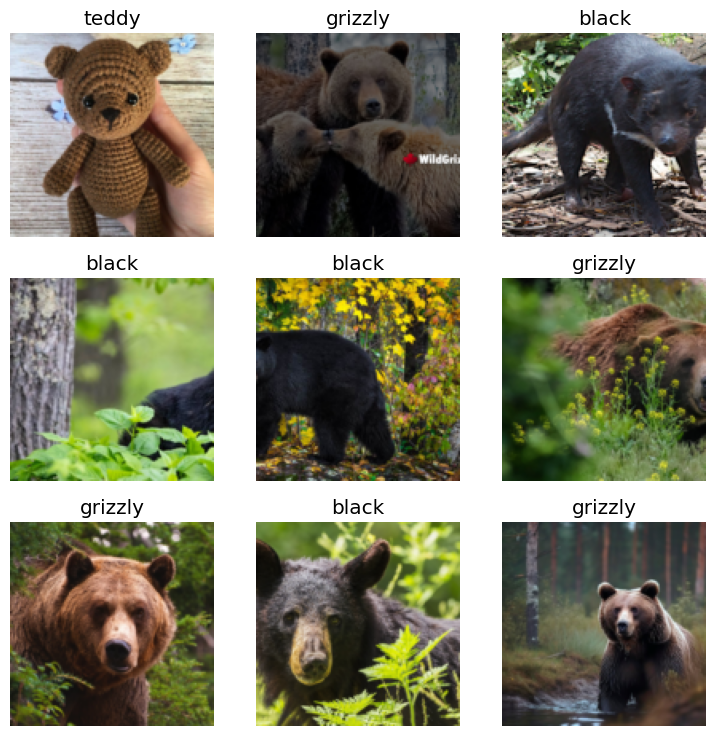

In [15]:
from fastai.vision.all import *
dls = ImageDataLoaders.from_folder(Path('bears'), valid_pct=0.2, item_tfms=Resize(128))
dls.show_batch(max_n=9)

In [16]:
fns = get_image_files(path)
fns

(#150) [Path('bears/black/000041.jpeg'),Path('bears/black/000023.jpg'),Path('bears/black/000025.jpg'),Path('bears/black/000008.jpg'),Path('bears/black/000036.jpg'),Path('bears/black/000034.jpg'),Path('bears/black/000044.jpg'),Path('bears/black/000018.jpg'),Path('bears/black/000019.jpg'),Path('bears/black/000017.jpg'),Path('bears/black/000028.jpg'),Path('bears/black/000024.jpg'),Path('bears/black/000026.jpg'),Path('bears/black/000039.jpg'),Path('bears/black/000003.jpg'),Path('bears/black/000043.jpg'),Path('bears/black/000037.jpeg'),Path('bears/black/000040.jpg'),Path('bears/black/000042.jpg'),Path('bears/black/000046.jpg')...]

In [17]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink);

In [18]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [19]:
dls = bears.dataloaders(path)

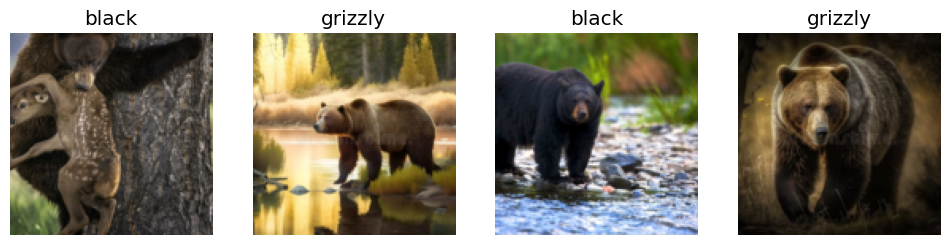

In [20]:
dls.valid.show_batch(max_n=4, nrows=1)

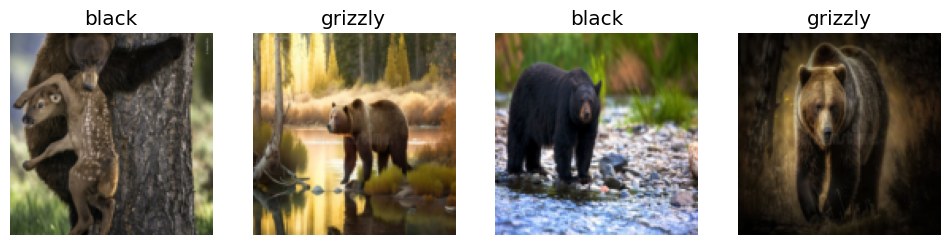

In [21]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

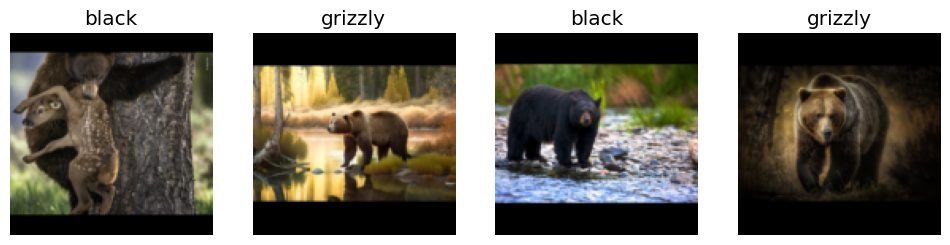

In [22]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

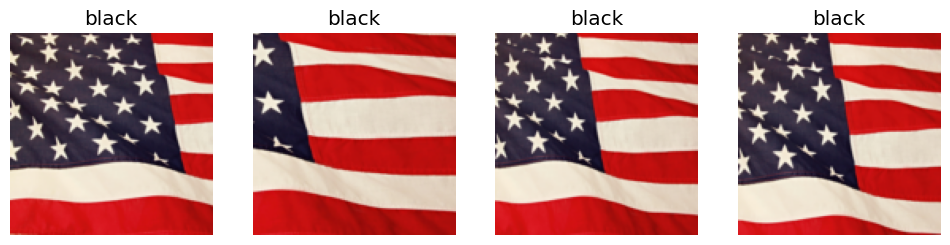

In [23]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

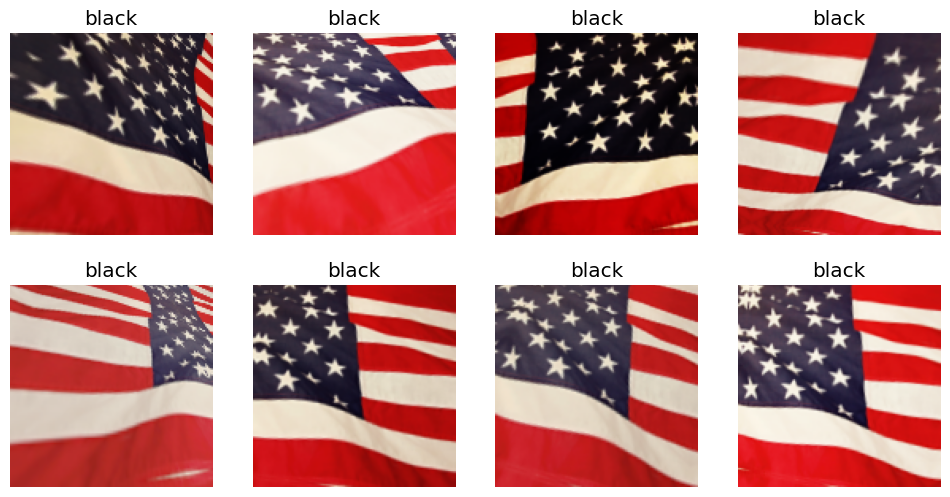

In [24]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [40]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [41]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.950692,2.092475,0.550000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,2.186502,1.355636,0.550000,00:03
1,1.833154,0.274003,0.150000,00:04
2,1.443210,0.096929,0.000000,00:03
3,1.177638,0.067313,0.000000,00:03


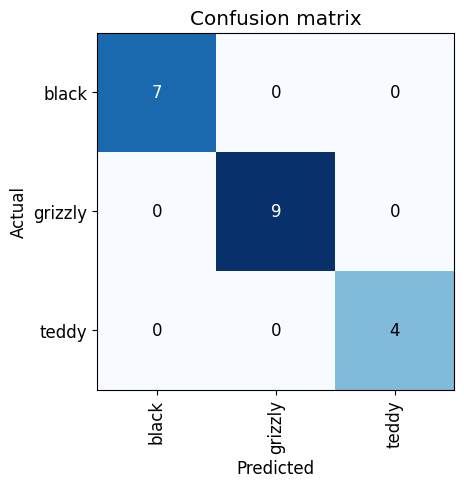

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

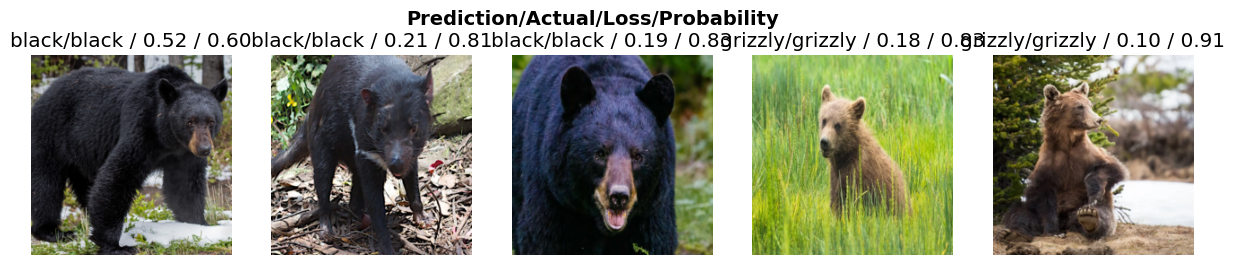

In [43]:
interp.plot_top_losses(5, nrows=1)

In [44]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [39]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [45]:
learn.export()

In [46]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [47]:
learn_inf = load_learner(path/'export.pkl')

/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [48]:
learn_inf.predict('/content/bears/black/000013.jpg')

('black', tensor(0), tensor([0.9882, 0.0093, 0.0025]))

In [49]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [50]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [51]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['/content/bears/black/000013.jpg'])

In [52]:
img = PILImage.create(btn_upload.data[-1])

In [53]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [54]:
pred,pred_idx,probs = learn_inf.predict(img)

In [55]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: black; Probability: 0.9882')

In [56]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [57]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [58]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [59]:
#hide_output
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [60]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r bears /content/drive/MyDrive/
!cp export.pkl /content/drive/MyDrive/

Mounted at /content/drive
